In [1]:
import sklearn
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score

## Load of training data ##

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Transforms text into Bag of Words normalized vectors

In [5]:
text_transform = TfidfVectorizer(stop_words='english', max_features=12000)
text_transform.fit(df.comment_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=12000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [6]:
X = text_transform.transform(df.comment_text)

In [7]:
target_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [8]:
y = np.array(df[target_labels])

In [9]:
X.shape

(159571, 12000)

### Split train data into training/validation ###

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.3)

In [11]:
X_train

<111699x12000 sparse matrix of type '<class 'numpy.float64'>'
	with 2520964 stored elements in Compressed Sparse Row format>

In [12]:
nr_targets = Y_train.shape[-1]

In [13]:
nr_targets

6

### Choosing the Model ###

Create a model that compounds multiples Logistic Linear Classifier, one for each binary target (`toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, `identity_hate`)

In [14]:
class Model(object):
    def __init__(self, nr_targets, *args, **kwargs):
        self.models = [SGDClassifier(loss='log', *args, **kwargs)
                       for i in range(nr_targets)]
    
    def fit(self, X, Y):
        for model, y in zip(self.models, Y.T):
            model.fit(X_train, y)
            
    def predict_proba(self, xs):
        return np.column_stack([m.predict_proba(xs)[...,1] for m in self.models])
    
    def predict(self, xs):
        return self.predict_proba(xs) >= 0.5

In [15]:
model = Model(nr_targets, max_iter=1000)

## Training ##

In [16]:
model.fit(X_train, Y_train)

## Evaluation of the trained models ##

In [17]:
train_predictions = model.predict_proba(X_train)
val_predictions = model.predict_proba(X_val)

In [18]:
def print_confusion_matrices(pred_ys, ys):
    plt.figure(figsize=(12,6))
    for i, (y_true, y_pred) in enumerate(zip(ys.T, pred_ys.T)):
        matrix = metrics.confusion_matrix(y_true, y_pred)
        matrix = matrix/np.sum(matrix)
        labels = ["false", "true"]
        plt.subplot(2, 3, i+1)
        #plt.xlabel('True')
        #plt.ylabel('Predicted')
        plt.title(target_labels[i])
        sns.heatmap(matrix, annot=True, xticklabels=labels, yticklabels=labels)
    plt.show()

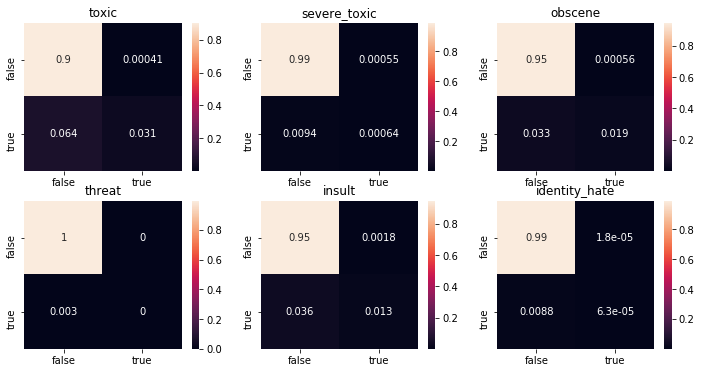

In [19]:
print_confusion_matrices(train_predictions >= 0.5, Y_train)

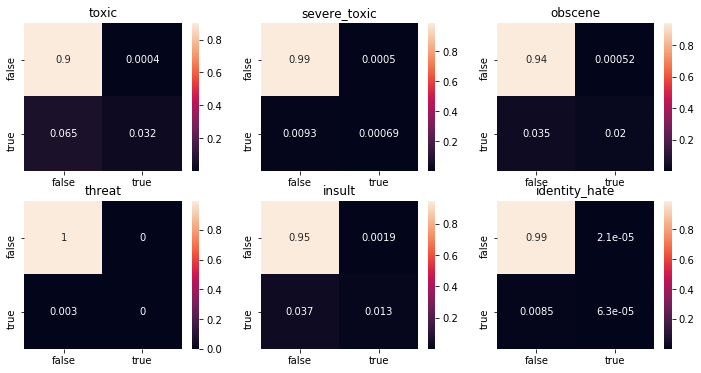

In [20]:
print_confusion_matrices(val_predictions >= 0.5, Y_val)

In [21]:
print("Training accuracy: {:.4f}".format(metrics.roc_auc_score(y_true=Y_train, y_score=train_predictions)))
print("Validation accuracy: {:.4f}".format(metrics.roc_auc_score(y_true=Y_val, y_score=val_predictions)))

Training accuracy: 0.9775
Validation accuracy: 0.9715


### Test submission ###

In [24]:
test_df = pd.read_csv('data/test.csv')

In [53]:
indices = ['id',
           'toxic',
           'severe_toxic',
           'obscene',
           'threat',
           'insult',
           'identity_hate']

X_test = text_transform.transform(test_df.comment_text)
test_predictions = model.predict_proba(X_test)
submission = pd.DataFrame(np.column_stack([test_df.id, test_predictions]),
                          columns=indices)

In [58]:
submission.to_csv('submission.csv', index=False, float_format='%.4f')